 <h2> Исследование - Классифицикация коментариев для интернет магазина.  C BERT<a class=\"tocSkip\"> </h2>

Логичным этапом развития проекта является его внедрение в бизнес-концепцию. Зачастую это либо публикация в сети или обновление действующего приложения и передача новых возможностей пользователям. Грамотное внедрение позволяет безболезненно и быстро включить новый функционал в бизнес-процессы и получать выгоду с первого дня использования.

В нашем случае интернет-магазин  дает новые возможностей пользователям, происходит запуск новых сервисов. Теперь пользователи могут редактировать и дополнять описания товаров. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

<h2> Цель работы <a class=\"tocSkip\"> </h2>

Построить модель которая умеет классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.
Значение метрики качества F1 должно быть не меньше 0.75. 

<h2> Основные шаги <a class=\"tocSkip\"> </h2>

- Загрузить данные
- Проанализировать данные.
- Обучить разные модели с различными гиперпараметрами.
- Проверить данные на тестовой выборке.
- Сделать общий вывод.

<h2> Описание данных <a class=\"tocSkip\"> </h2>

Данные находятся в файле /datasets/toxic_comments.csv.

Столбец text в нём содержит текст комментария, а toxic — целевой признак.

In [82]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [83]:
! pip install torch -q

In [84]:
import torch


if torch.cuda.is_available():
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print("Имеются в наличии:", torch.cuda.device_count(), 'gpu')
  print('Мы будем использовать графический процессор:', torch.cuda.get_device_name())
else:
  print("Не, все фигня, давай по новой...")
  device = torch.device('cpu')

Имеются в наличии: 1 gpu
Мы будем использовать графический процессор: Tesla T4


In [85]:
! pip install transformers -q

In [86]:
!pip install catboost -q

In [87]:
!pip install lightgbm -q

In [88]:
# Импоритруем библиотеки 

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
from tqdm import notebook

from transformers import (
    # BertForSequenceClassification,
    BertModel,
    # get_linear_schedule_with_warmup,
    # AdamW, 
    BertConfig,
    BertTokenizer,
)

from torch.utils.data import (
    TensorDataset, 
    random_split,
    DataLoader, 
    RandomSampler,
    SequentialSampler
)
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import (
    train_test_split,
    cross_val_score
) 

from sklearn.metrics import f1_score

# from sklearn.preprocessing import StandardScaler

## Загрузка данных

In [89]:
# Прочитаем файл и запишем в переменную df
# Используем метод Tru - Except для стабильного подключения, в случаее если первый вариант пути будет не обнаружен.

try:
    df = pd.read_csv('/Users/ilyashirikov/Downloads/toxic_comments.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\n\nCongratulations from me as well, use the ...",0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,Your vandalism to the Matt Shirvington article...,0
8,8,Sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


,Unnamed: 0,toxic
count,159292.000000,159292.000000
mean,79725.697242,0.101612
std,46028.837471,0.302139
min,0.000000,0.000000
25%,39872.750000,0.000000
50%,79721.500000,0.000000
75%,119573.250000,0.000000
max,159450.000000,1.000000


None

array([[<Axes: title={'center': 'Unnamed: 0'}>,
        <Axes: title={'center': 'toxic'}>]], dtype=object)

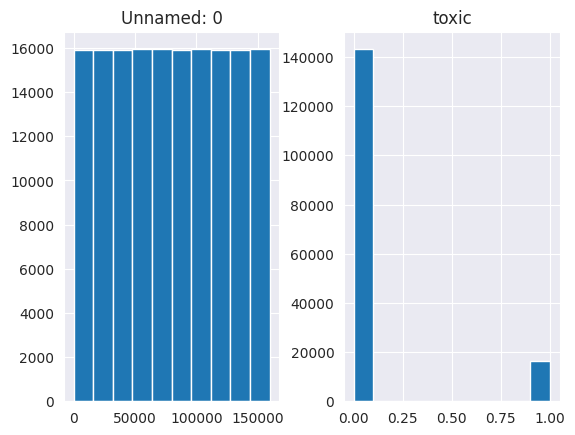

In [90]:
# Создадим функцию fanc() для вывода всех необходимых методов показа информации df

def info_func(i):
    info = display(i.head(10), i.describe(), i.info(), i.hist())

info_func(df)

In [91]:
df = df.drop('Unnamed: 0', axis=1)

In [92]:
df = df.sample(20000).reset_index(drop=True)
df.toxic.value_counts()

0    17960
1     2040
Name: toxic, dtype: int64

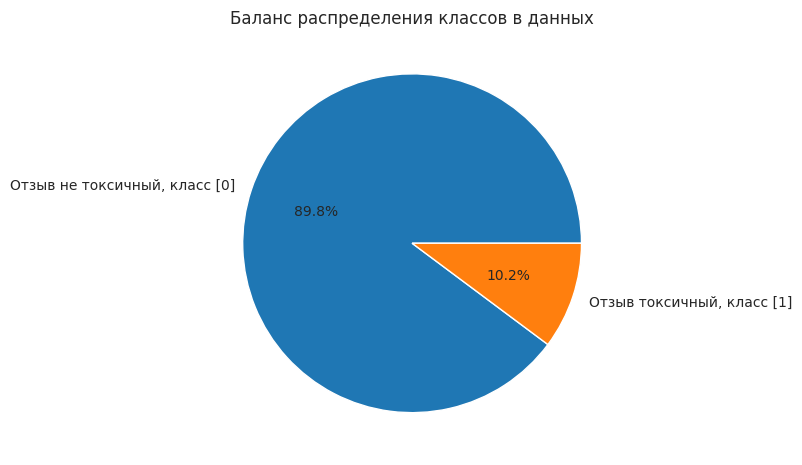

In [93]:
sns.set_style('darkgrid')
df['toxic'].value_counts(normalize=True).plot(kind='pie',figsize=[5.5,5.5], legend=False, autopct='%1.1f%%',labels=['Отзыв не токсичный, класс [0]','Отзыв токсичный, класс [1]'])
plt.title('Баланс распределения классов в данных')
plt.ylabel('')
plt.show()

**Выводы и результаты по анализу и подготовке данных:**
- В данных удален лишний столбец, дубликатов и пропусков не обнаоужено
- Анализ данных показал дисбаланс целевого признака


In [94]:

# corpus = df['text'].values

# nlp = spacy.load('en_core_web_sm')
# regex = re.compile(r'[^a-zA-Z]')

# def lemmatize_and_clear_text(text):
#     doc = nlp(text)
#     lem_text = [token.lemma_.lower() for token in doc if token.is_alpha]
#     text_out = ' '.join(lem_text)
#     text_out = regex.sub(' ', text_out)
#     return text_out

# for i in notebook.tqdm(range(len(corpus))):
#     corpus[i] = lemmatize_and_clear_text(corpus[i])

# df['text_lem'] = pd.Series(corpus)

In [95]:
# corpus_lem = df['text_lem'].values
# stopwords = set(stopwords.words('english'))

# tf_idf = TfidfVectorizer(stop_words=stopwords)
# tf_idf = tf_idf.fit_transform(corpus_lem)

# df['tf_idf'] = pd.Series(tf_idf)

## Реализация BERT

In [96]:

tokenizer = BertTokenizer.from_pretrained("unitary/toxic-bert" , do_lower_case=True)


In [97]:
tokenized = df.text.apply((lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True)))

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape


(20000, 512)

In [98]:
config = BertConfig.from_pretrained('unitary/toxic-bert')
model = BertModel.from_pretrained("unitary/toxic-bert", config=config,)

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [99]:
batch_size = 100
embeddings = []


for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
    if torch.cuda.is_available():
            # move tensors to CUDA device
        batch = batch.to(device)            
        attention_mask_batch = attention_mask_batch.to(device)
        model = model.to(device)
        
    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        batch_embeddings = batch_embeddings[0][:, 0, :]
    if torch.cuda.is_available():
    
         batch_embeddings = batch_embeddings.cpu()
         embeddings.append(batch_embeddings.numpy())


  0%|          | 0/200 [00:00<?, ?it/s]

## Обучение

Для обучения были выбраны модели: LogisticRegression, LaitGBMClassifier и CatBoostClassifier

In [100]:
# SIZE = 100_000

# df = pd.DataFrame(data={
#     'x': map('Текст {}'.format, range(1, SIZE + 1)),
#     'y': np.random.choice([0, 0, 0, 1], SIZE)
# })

# display(df)

# _, tmp = train_test_split(df,
#                           test_size=600,
#                           stratify=df['y'],
#                           random_state=42)

# print(tmp.shape)
# print(tmp['y'].mean())

# X_train, X_test, y_train, y_test = train_test_split(tmp.drop('y', axis=1),
#                                                      tmp['y'],
#                                                      test_size=150,
#                                                      stratify=tmp['y'],
#                                                      random_state=42)

# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
# print(y_train.mean(), y_test.mean())

# display(X_train)
# display(y_train)
# display(X_test)
# display(y_test)

features = np.concatenate(embeddings)
train = df['toxic']
features


array([[-0.6099801 , -0.8874288 ,  0.5839276 , ..., -0.6852361 ,
         0.47887313,  0.21803352],
       [-0.74619913, -0.867783  ,  0.38750178, ..., -0.82489216,
         0.4360352 ,  0.23175189],
       [ 0.04498926,  0.5355586 ,  0.62209886, ..., -0.2983643 ,
         0.22510022,  0.52812225],
       ...,
       [-0.6865706 , -0.9579159 ,  0.7087435 , ..., -0.75882643,
         0.3983448 ,  0.11502219],
       [-0.69297814, -1.0314568 ,  0.5406648 , ..., -0.6764253 ,
         0.55482984,  0.401732  ],
       [-0.6523018 , -0.8091144 ,  0.48002604, ..., -0.7004219 ,
         0.39153484, -0.01504377]], dtype=float32)

In [101]:
X_train, X_test, y_train, y_test = train_test_split(
    features, train, test_size=0.2, random_state=0)

### Логистическая регрессия

In [102]:
model_lg = LogisticRegression(random_state=0)
F1_lg = cross_val_score(model_lg, X_train, y_train, scoring='f1', cv=3, error_score='raise').mean()
print("F1 для LogisticRegression на обучающей выборке:", round(F1_lg, 2))

F1 для LogisticRegression на обучающей выборке: 0.94


### CatBoostClassifier

In [103]:
cat = CatBoostClassifier(iterations=100,
                        random_state=0,
                        learning_rate=0.4,
                        depth=5,
                        verbose=10)

F1_cat = cross_val_score(cat, X_train, y_train, scoring='f1', cv=3, error_score='raise').mean()
print("F1 для CatBoostClassifier на обучающей выборке:", round(F1_cat, 2))

0:	learn: 0.1639144	total: 141ms	remaining: 13.9s
10:	learn: 0.0251354	total: 1.26s	remaining: 10.2s
20:	learn: 0.0171630	total: 2.31s	remaining: 8.69s
30:	learn: 0.0127075	total: 3.38s	remaining: 7.53s
40:	learn: 0.0095792	total: 5.26s	remaining: 7.57s
50:	learn: 0.0077655	total: 7.09s	remaining: 6.81s
60:	learn: 0.0055748	total: 8.17s	remaining: 5.22s
70:	learn: 0.0041047	total: 9.24s	remaining: 3.77s
80:	learn: 0.0030534	total: 10.3s	remaining: 2.42s
90:	learn: 0.0024905	total: 11.4s	remaining: 1.12s
99:	learn: 0.0020533	total: 12.3s	remaining: 0us
0:	learn: 0.1516524	total: 161ms	remaining: 16s
10:	learn: 0.0203637	total: 1.25s	remaining: 10.1s
20:	learn: 0.0133671	total: 2.33s	remaining: 8.76s
30:	learn: 0.0096668	total: 3.4s	remaining: 7.58s
40:	learn: 0.0073478	total: 5.39s	remaining: 7.76s
50:	learn: 0.0058133	total: 7.19s	remaining: 6.91s
60:	learn: 0.0041604	total: 8.26s	remaining: 5.28s
70:	learn: 0.0030310	total: 9.33s	remaining: 3.81s
80:	learn: 0.0023034	total: 10.4s	rema

### LGBMClassifier

In [104]:
lgbm = LGBMClassifier(iterations=100,
                      random_state=0,
                      learning_rate=0.4,
                      depth=5,
                      verbose=10)
F1_lgbm = cross_val_score(lgbm, X_train, y_train, scoring='f1', cv=3, error_score='raise').mean()
print("F1 для LGBMClassifier на обучающей выборке:", round(F1_lgbm, 2))

[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Info] Number of positive: 1105, number of negative: 9561
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.000000
[LightGBM] [Debug] init for col-wise cost 0.000047 seconds, init for row-wise cost 0.167585 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.204896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 10666, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.103600 -> initscore=-2.157847
[LightGBM] [Info] Start training from score -2.157847
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11

In [105]:
pd.DataFrame(data = [[round(F1_lg, 2)],
                    [round(F1_cat, 2)],
                    [round(F1_lgbm, 2)]],
             index = ['LogisticRegression', 'CatBoostClassifier', 'LGBMClassifier'],
             columns = ['F1']
             )

,F1
LogisticRegression,0.94
CatBoostClassifier,0.93
LGBMClassifier,0.94


### Логистическая регрессия на тестовой выборке


In [106]:
model_lg_t = LogisticRegression(random_state=0)
model_lg_t.fit(X_train, y_train)
prediction = model_lg_t.predict(X_test)
f1_t = f1_score(y_test, prediction, average='binary')
print("F1 для LogisticRegression на тестовой выборке:", round(f1_t, 2))

F1 для LogisticRegression на тестовой выборке: 0.93


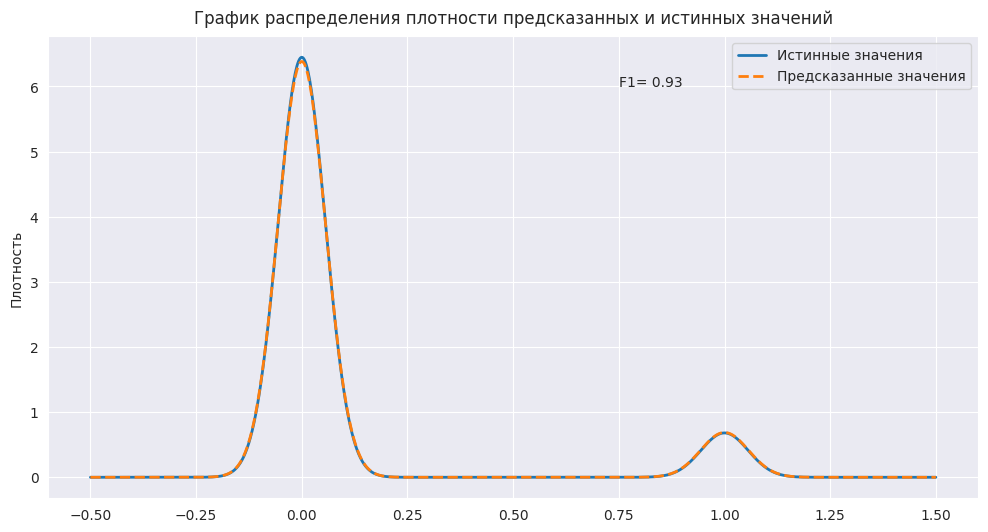

In [107]:
# Визуализирую реальные и предсказанные значения тестовой выборки
def graph_analis(true, predict):
    f1 = f1_score(y_test, predict)
    plt.figure(figsize=(12,6))
    true.plot(kind='kde', linewidth=2)
    pd.Series(predict).plot(kind='kde',linewidth=2, linestyle = '--')
    plt.title('График распределения плотности предсказанных и истинных значений', y=1.01)
    plt.legend(['Истинные значения','Предсказанные значения'])
    plt.text(0.75,6,'F1= {:.2f}'.format(f1))
    plt.xlabel('')
    plt.ylabel('Плотность')
    plt.show()

graph_analis(y_test, prediction)

## Общий вывод

Было проведено исследование где необходимо было найти инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

В ходе работы была реализована модель BERT, данная модель лучше подходит для работы с текстовыми данными.

Для обучения были выбраны модели: LogisticRegression, LaitGBMClassifier и CatBoostClassifier, на обучающей выборке все модели показали почти одинаковый результат в 0.94, LogisticRegression показала 0.95 окгда пороговое значение было 0.75, в ходе проверки на тестовых данных взяли Логистическую регрессию котрая показла результат в 0.93.